In [20]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models,transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [21]:
dataset_path = r"D:\ml_projects\haar_caascade\dataset_utk\UTKFace\crop_part1"
image_files = os.listdir(dataset_path)

In [22]:
def preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image = image / 255.0  
    
    return image

In [23]:
def extract_age(filename):
    return int(filename.split('_')[0])

In [24]:
images = []
ages = []  
for file in tqdm(image_files):
    image_path = os.path.join(dataset_path, file)
    image = preprocess_image(image_path)
    images.append(image)
    ages.append(extract_age(file))  

100%|██████████| 9780/9780 [00:11<00:00, 874.56it/s] 


In [25]:
images = np.array(images, dtype=np.float32)
ages = np.array(ages, dtype=np.float32)

In [37]:
# Convert images and ages to NumPy arrays
images = np.array(images, dtype=np.float32)
ages = np.array(ages, dtype=np.float32)  # Ensure ages are also a NumPy array

In [38]:
print(ages[:5])

[100. 100. 101.  10.  10.]


In [39]:
print(f'Total images: {images.shape}')

Total images: (9780, 128, 128, 3)


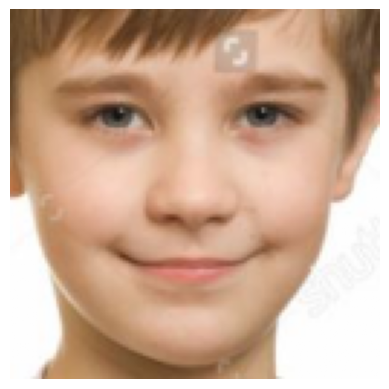

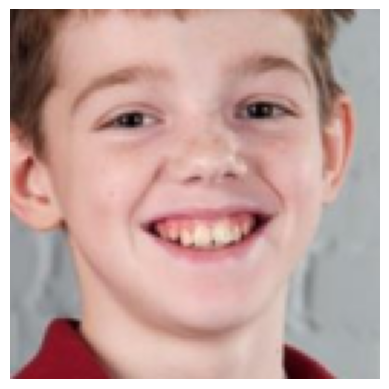

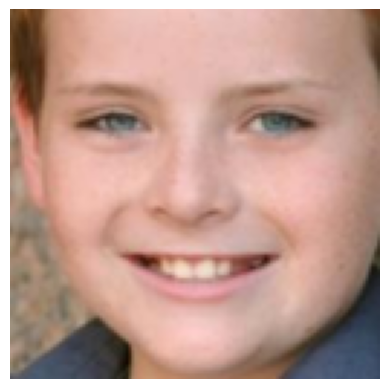

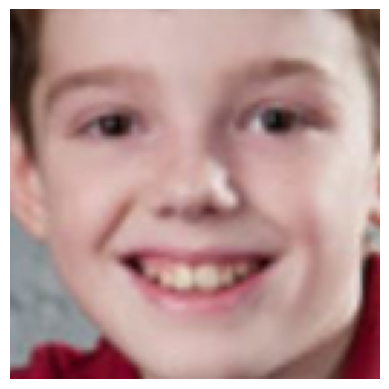

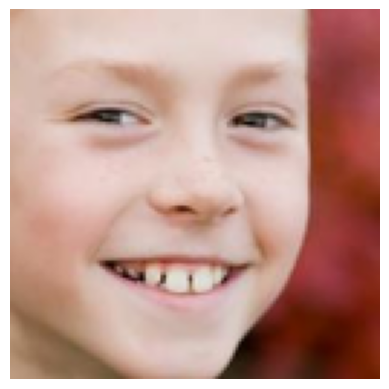

In [40]:
import matplotlib.pyplot as plt
for i in range(50,55): 
    plt.figure()
    plt.imshow(images[i])  
    plt.axis('off')  
    plt.show()

In [41]:
X_train, X_val, y_train, y_val = train_test_split(images, ages, test_size=0.2, random_state=82)

print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')


Training set size: 7824
Validation set size: 1956


In [42]:
# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

In [43]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [44]:

model = models.resnet18(pretrained=True)

for name, param in model.named_parameters():
    if 'layer4' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Single output node for regression


c:\Users\ABHIRAM\anaconda3\envs\amazonml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ABHIRAM\anaconda3\envs\amazonml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
criterion = nn.MSELoss()  # Suitable for age regression
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adjusted learning rate

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [47]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model = model.to(device)  # Move model to the specified device

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            # Permute the dimensions to [batch_size, channels, height, width]
            images = images.permute(0, 3, 1, 2)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs.squeeze(), labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            train_loss += loss.item() * images.size(0)

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()

                # Permute the dimensions for validation as well
                images = images.permute(0, 3, 1, 2)

                outputs = model(images)  # Forward pass
                loss = criterion(outputs.squeeze(), labels)  # Calculate loss
                val_loss += loss.item() * images.size(0)

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)

        # Print the loss for this epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

In [48]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch 1/10, Training Loss: 580.8863, Validation Loss: 184.5743
Epoch 2/10, Training Loss: 130.2752, Validation Loss: 105.4169
Epoch 3/10, Training Loss: 78.7926, Validation Loss: 86.8258


KeyboardInterrupt: 

Training Stopped Early To Avoid Overfitting

In [ ]:
torch.save(model.state_dict(), "age_prediction_model_new.pth")

In [ ]:
images = []
ages = []  
for file in tqdm(image_files):
    image_path = os.path.join(dataset_path, file)
    if os.path.isfile(image_path):  # Check if the file path is valid
        image = preprocess_image(image_path)
        images.append(image)
        ages.append(extract_age(file))

# Convert to NumPy arrays
images = np.array(images, dtype=np.float32)
ages = np.array(ages, dtype=np.float32)

# Debug information
print(f'Total images processed: {len(images)}')
print(f'Total ages collected: {len(ages)}')

# Now verify the shapes again
print(f'Shape of images: {images.shape}')
print(f'Shape of ages: {ages.shape}')


Mean Squared Error on the entire dataset: 35.3780


so rms loss is sqrt(35.3780)

In [99]:
np.sqrt(35.37800)

5.947940820149441

so error is +/- 5.9479 years

5.947940820149441

Testing on a Known Outside Image of a Subject of age 19 years

C:\Users\ABHIRAM\AppData\Local\Temp\ipykernel_14612\1948639479.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'D:\ml_projects\thanuj_

Predicted Age: 12.45


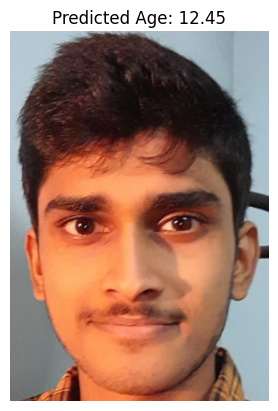

In [17]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models


def preprocess_single_image(image_path, target_size=(128, 128)):
    # Load the image
    image = cv2.imread(image_path)
    # Resize the image
    image = cv2.resize(image, target_size)
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Normalize the image
    image = image / 255.0
    # Convert to tensor and change from HWC to CHW
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Change from HWC to CHW
    image = image.unsqueeze(0)  # Add batch dimension
    return image

model = models.resnet18(pretrained=True)

# Freeze all layers except 'layer4'
for name, param in model.named_parameters():
    if 'layer4' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the fully connected layer for regression (single output)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

# Load the saved model parameters
model.load_state_dict(torch.load(r'D:\ml_projects\thanuj_proj_1\age_prediction_model.pth'))

# Set to evaluation mode if needed
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Path to the single image you want to test
image_path = r"C:\Users\ABHIRAM\Downloads\pavan2.jpg"

# Preprocess the image
input_image = preprocess_single_image(image_path).to(device)  # Convert to tensor and move to device
# Make prediction
with torch.no_grad():  # Disable gradient calculation
    output = model(input_image).squeeze()  # Get the model output
    predicted_age = output.item()  # Convert to a Python number

# Print the predicted age
print(f"Predicted Age: {predicted_age:.2f}")

# Visualize the image and predicted age
# Load the original image for visualization
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Display the image with the predicted age
plt.imshow(original_image)
plt.title(f"Predicted Age: {predicted_age:.2f}")
plt.axis('off')  # Hide axes
plt.show()


Testing on Trained Dataset

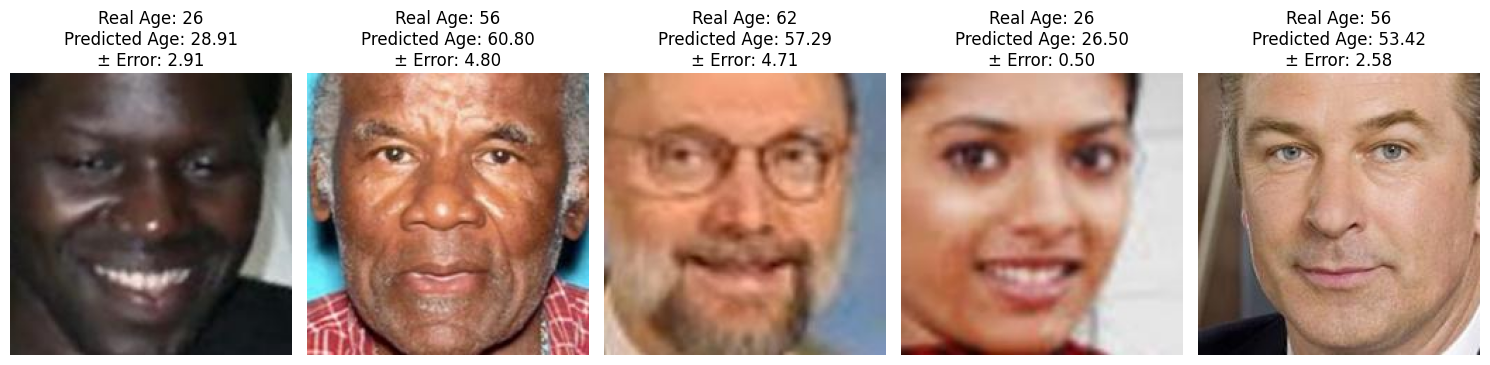

In [29]:
import random
import matplotlib.pyplot as plt
import cv2
import torch

# Function to preprocess a single image
def preprocess_single_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Change from HWC to CHW
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Function to get the real age from the filename
def extract_age(filename):
    return int(filename.split('_')[0])

# Function to plot, predict, and show age differences for random images
def plot_and_predict_random_images(image_files, model, num_images=5):
    # Randomly select images
    selected_files = random.sample(image_files, num_images)
    
    # Prepare for plotting
    plt.figure(figsize=(15, 10))
    
    for i, file in enumerate(selected_files):
        image_path = os.path.join(dataset_path, file)
        input_image = preprocess_single_image(image_path).to(device)
        
        # Get the real age
        real_age = extract_age(file)
        
        # Make prediction
        with torch.no_grad():
            output = model(input_image).squeeze()  # Get the model output
            predicted_age = output.item()  # Convert to a Python number
        
        # Calculate absolute error
        error = abs(predicted_age - real_age)
        
        # Load original image for visualization
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        
        # Plot the image, predicted age, real age, and error
        plt.subplot(1, num_images, i + 1)
        plt.imshow(original_image)
        plt.title(f"Real Age: {real_age}\nPredicted Age: {predicted_age:.2f}\n± Error: {error:.2f}")
        plt.axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()

# Call the function to plot and predict ages
plot_and_predict_random_images(image_files, model, num_images=5)  # Change num_images as needed
